In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import unittest

In [2]:
connection = sqlite3.connect('assignment_db.db')
cursor = connection.cursor()

def create_table_from_csv(file_path, table_name):
    """
    Given a path to a csv file and table_name, it will read the file and create a table
    in the database with the given table_name and insert into it the dava from the csv
    """
    try:
        with open(file_path, 'r') as file:
            #Extract columns
            headers = file.readline().strip()
            cols = headers.split(',')
            num_cols = len(cols)
            query_cols = ' float,\n'.join(cols) + ' float'

            #If a table with a similar name exists, drop it
            cursor.execute(f'DROP TABLE IF EXISTS {table_name}')

            #Create table
            query = f"""
            CREATE TABLE {table_name}(
            {query_cols}
            )
            """
            cursor.execute(query)

            #Insert data into the table
            for row in file:
                cursor.execute(f"INSERT INTO {table_name} VALUES ({('?,'*num_cols)[:-1]})", row.strip().split(","))
                connection.commit()
            print(f'Successfully created {table_name}')
    except Exception as e:
        print(f'Error: {e}')

create_table_from_csv('data/train.csv', 'train_set')
create_table_from_csv('data/test.csv', 'test_set')
create_table_from_csv('data/ideal.csv', 'ideal_set')

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print('All tables in DB:\n',cursor.fetchall())

cursor.close()
connection.close()

Successfully created train_set
Successfully created test_set
Successfully created ideal_set
All tables in DB:
 [('mapped_set',), ('train_set',), ('test_set',), ('ideal_set',)]


In [3]:
def query_assignment_db(query):
    """Establishes a connection to the database, executes the given query, and returns the resulting dataframe"""
    try:
        connection = sqlite3.connect('assignment_db.db')
        df = pd.read_sql(query, connection)
        connection.close()
        return df
    except Exception as e:
        print(f'Error: {e}')
        return

In [4]:
train = query_assignment_db('SELECT * FROM train_set')
test = query_assignment_db('SELECT * FROM test_set')
ideal = query_assignment_db('SELECT * FROM ideal_set')

In [5]:
class IdealFunction():
    """Creates an object of an ideal function. Values of x and y are stored as numpy arrays"""
    def __init__(self, ideal_col):
        self.x = ideal['x'].values
        self.y = ideal[ideal_col].values
        self.ideal_col = ideal_col

# create and save all ideal function objects as a dictionary for easy access
ideal_funcs = {}
for col in ideal.columns:
    if col != 'x':
        ideal_funcs[col] = IdealFunction(col)


class RepresentativeIdealFunction(IdealFunction):
    """
    Creates an object of a representative ideal function: that is an ideal function
    that has been found to have a corresponding function in the training data set.
    It inherits from the IdealFunction class

    It takes in a column names in the ideal and training datasets and computes
    characteristics such as sum of squared deviations and maximum deviation between
    the training an dideal functions
    """
    def __init__(self, ideal_col, train_col):
        super().__init__(ideal_col)
        self.train_y = train[train_col]
    @property
    def sum_deviations(self):
        return np.square(self.y - self.train_y).sum()
    @property
    def max_deviation(self):
        return np.abs(self.y - self.train_y).max()


class TrainFunction():
    """
    Creates an object of the training function, identifies the corresponding ideal function
    """
    def __init__(self, train_col):
        self.x = train['x'].values
        self.y = train[train_col].values
        self.train_col = train_col

    @property
    def deviations(self):
        return {ideal_col: np.square(self.y - ideal_func.y).sum() for ideal_col, ideal_func in ideal_funcs.items()}

    @property
    def corresponding_ideal_func(self):
        ideal_func_label = min(self.deviations, key = self.deviations.get)
        return RepresentativeIdealFunction(ideal_func_label, self.train_col)

# create and save all train function objects as a dictionary for easy access
train_funcs = {}
for col in train.columns:
    if col != 'x':
        train_funcs[col] = TrainFunction(col)

repr_ideal_funcs = [train_func.corresponding_ideal_func for train_func in train_funcs.values()]

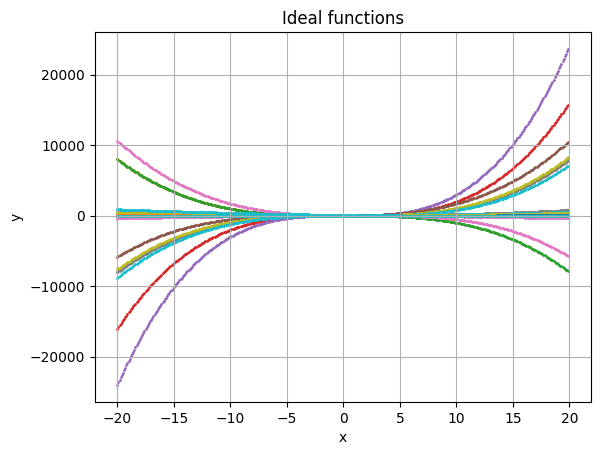

In [6]:
for ideal_col, ideal_func in ideal_funcs.items():
    plt.scatter(ideal_func.x, ideal_func.y, label = ideal_col, s = 1)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ideal functions')
# plt.legend()
plt.show()

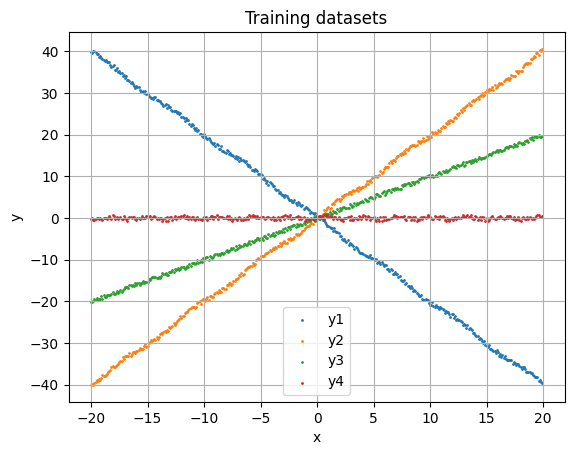

In [7]:
for train_col, train_func in train_funcs.items():
    plt.scatter(train_func.x, train_func.y, label = train_col, s = 1)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training datasets')
plt.legend()
plt.show()

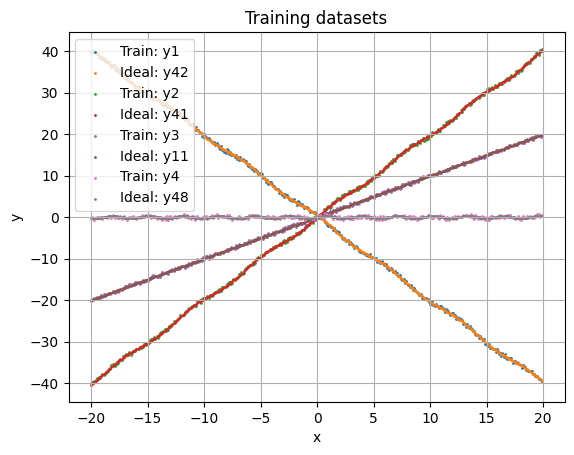

In [8]:
for train_col, train_func in train_funcs.items():
    plt.scatter(train_func.x, train_func.y, label = f'Train: {train_col}', s = 1)
    plt.scatter(train_func.corresponding_ideal_func.x,
                train_func.corresponding_ideal_func.y,
                label = f'Ideal: {train_func.corresponding_ideal_func.ideal_col}', s = 1)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training datasets')
plt.legend()
plt.show()

In [9]:
best_fit_df = pd.DataFrame([{
    'train_col': train_func.train_col,
    'ideal_col': train_func.corresponding_ideal_func.ideal_col,
    'sum_deviations': train_func.corresponding_ideal_func.sum_deviations,
    'max_deviation': train_func.corresponding_ideal_func.max_deviation
} for train_func in train_funcs.values()])

best_fit_df

,train_col,ideal_col,sum_deviations,max_deviation
0,y1,y42,34.246594,0.495968
1,y2,y41,35.601847,0.497703
2,y3,y11,29.861830,0.498936
3,y4,y48,31.963434,0.499742


In [10]:
def find_close_ideal_func(test_x,test_y, repr_ideal_funcs = repr_ideal_funcs):
    for repr_ideal_func in repr_ideal_funcs:
        distances = np.hypot((repr_ideal_func.x - test_x), (repr_ideal_func.y - test_y))
        argmin = np.argmin(distances)
        if distances.min() <= repr_ideal_func.max_deviation * np.sqrt(2):
            return dict(ideal_col = repr_ideal_func.ideal_col,
                        close_x = repr_ideal_func.x[argmin],
                        close_y = repr_ideal_func.y[argmin]
                       )
    return dict(ideal_col = None, close_x = None, close_y = None)

In [11]:
test['corresponding_ideal_func'] = test.apply(lambda row: find_close_ideal_func(row['x'], row['y'])['ideal_col'], axis = 1)
test['close_x'] = test.apply(lambda row: find_close_ideal_func(row['x'], row['y'])['close_x'], axis = 1)
test['close_y'] = test.apply(lambda row: find_close_ideal_func(row['x'], row['y'])['close_y'], axis = 1)
test['delta_y'] = np.abs(test['y'] - test['close_y'])
test['has_ideal_func'] = test['corresponding_ideal_func'].notna()
test['has_ideal_func'].value_counts()

has_ideal_func
True     73
False    27
Name: count, dtype: int64

In [12]:
test

,x,y,corresponding_ideal_func,close_x,close_y,delta_y,has_ideal_func
0,17.5,34.161040,y41,17.4,34.303670,0.142630,True
1,0.3,1.215102,y42,-0.2,0.890033,0.325069,True
2,-8.7,-16.843908,y41,-8.3,-17.051086,0.207178,True
3,-19.2,-37.170870,y41,-18.7,-37.325500,0.154630,True
4,-11.0,-20.263054,y41,-10.5,-20.560152,0.297098,True
...,...,...,...,...,...,...,...
95,-1.9,-4.036904,y41,-1.8,-4.086924,0.050019,True
96,12.2,-0.010358,y48,12.3,-0.126974,0.116616,True
97,16.5,-33.964134,y42,16.8,-33.830338,0.133796,True
98,5.3,-10.291622,y42,5.3,-10.322813,0.031191,True


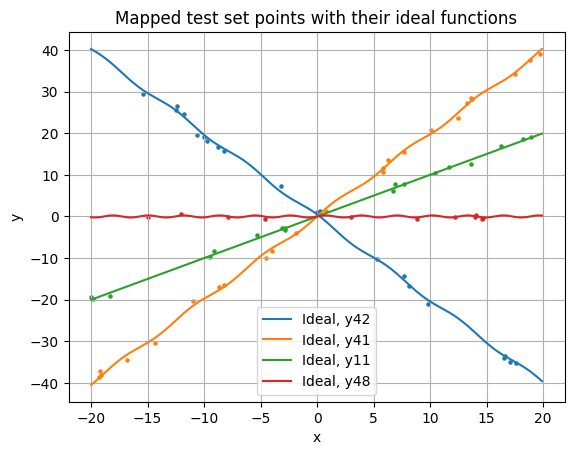

In [13]:
for repr_ideal_func in repr_ideal_funcs:
    ideal_col = repr_ideal_func.ideal_col
    plt.plot(repr_ideal_func.x, repr_ideal_func.y, label = f'Ideal, {ideal_col}')
    test_set_for_this_func = test.query('corresponding_ideal_func == @ideal_col')
    plt.scatter(test_set_for_this_func['x'], test_set_for_this_func['y'], s = 5)
    
plt.grid()
plt.title('Mapped test set points with their ideal functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [14]:
connection = sqlite3.connect('assignment_db.db')
cursor = connection.cursor()

table_name = "mapped_set"
cursor.execute(f'DROP TABLE IF EXISTS {table_name}')
create_table_query = f"""
CREATE TABLE {table_name}(
            x float,
            y float,
            ideal_func varchar(255),
            y_ideal float,
            delta_y float
            )
"""
cursor.execute(create_table_query)
for index, row in test.query('has_ideal_func')[['x', 'y', 'corresponding_ideal_func', 'close_y', 'delta_y']].iterrows():
    cursor.execute(f"INSERT INTO {table_name} VALUES ({('?,'*5)[:-1]})", list(row))
    connection.commit()
print(f'Successfully created {table_name}')
cursor.close()
connection.close()

Successfully created mapped_set


In [15]:
mapped_set = query_assignment_db('SELECT * FROM mapped_set')
mapped_set

,x,y,ideal_func,y_ideal,delta_y
0,17.5,34.161040,y41,34.303670,0.142630
1,0.3,1.215102,y42,0.890033,0.325069
2,-8.7,-16.843908,y41,-17.051086,0.207178
3,-19.2,-37.170870,y41,-37.325500,0.154630
4,-11.0,-20.263054,y41,-20.560152,0.297098
...,...,...,...,...,...
68,-12.4,26.599438,y42,26.272430,0.327008
69,-1.9,-4.036904,y41,-4.086924,0.050019
70,12.2,-0.010358,y48,-0.126974,0.116616
71,16.5,-33.964134,y42,-33.830338,0.133796


In [16]:
fake_train = pd.DataFrame()
fake_train['x'] = [1,2,3,4,5,6,7,8,9]
fake_train['y1'] = (fake_train['x']*2)+0.05
fake_train['y2'] = fake_train['x'] + 0.05
fake_train['y3'] = (fake_train['x']*-1)+0.05

fake_ideal = pd.DataFrame()
fake_ideal['x'] = [1,2,3,4,5,6,7,8,9]
fake_ideal['y1']= fake_ideal['x']
fake_ideal['y2']= np.square(fake_ideal['x'])
fake_ideal['y3']= fake_ideal['x']*2
fake_ideal['y4']= fake_ideal['x']*-1
fake_ideal['y5']= np.sqrt(fake_ideal['x'])

train = fake_train
ideal = fake_ideal

ideal_funcs = {}
for col in ideal.columns:
    if col != 'x':
        ideal_funcs[col] = IdealFunction(col)

train_funcs = {}
for col in train.columns:
    if col != 'x':
        train_funcs[col] = TrainFunction(col)
repr_ideal_funcs = [train_func.corresponding_ideal_func for train_func in train_funcs.values()]

In [22]:

class TestIdealFunctionMapping(unittest.TestCase):
    @staticmethod
    def generate_values_for_testing():
        fake_train = pd.DataFrame()
        fake_train['x'] = [1,2,3,4,5,6,7,8,9]
        fake_train['y1'] = (fake_train['x']*2)+0.05
        fake_train['y2'] = fake_train['x'] + 0.05
        fake_train['y3'] = (fake_train['x']*-1)+0.05
    
        fake_ideal = pd.DataFrame()
        fake_ideal['x'] = [1,2,3,4,5,6,7,8,9]
        fake_ideal['y1']= fake_ideal['x']
        fake_ideal['y2']= np.square(fake_ideal['x'])
        fake_ideal['y3']= fake_ideal['x']*2
        fake_ideal['y4']= fake_ideal['x']*-1
        fake_ideal['y5']= np.sqrt(fake_ideal['x'])
    
        train = fake_train
        ideal = fake_ideal
        
        ideal_funcs = {}
        for col in ideal.columns:
            if col != 'x':
                ideal_funcs[col] = IdealFunction(col)

        train_funcs = {}
        for col in train.columns:
            if col != 'x':
                train_funcs[col] = TrainFunction(col)
        repr_ideal_funcs = [train_func.corresponding_ideal_func for train_func in train_funcs.values()]
        return ideal_funcs, train_funcs, repr_ideal_funcs
        

    def test_ideal_function_for_train_set(self):
        ideal_funcs, train_funcs, repr_ideal_funcs = self.generate_values_for_testing()
        expected_total_deviation = round(9*0.05*0.05, 4)
        expected_ideal_cols = dict(y1 = 'y3', y2 = 'y1', y3 = 'y4')
        
        for train_col in train_funcs.keys():
            self.assertEqual(round(train_funcs[train_col].corresponding_ideal_func.max_deviation, 2), 0.05)
            self.assertEqual(round(train_funcs[train_col].corresponding_ideal_func.sum_deviations, 4), expected_total_deviation)
            self.assertEqual(train_funcs[train_col].corresponding_ideal_func.ideal_col, expected_ideal_cols[train_col])

    def test_assigning_point_to_ideal_func_when_it_exists(self):
        ideal_funcs, train_funcs, repr_ideal_funcs = self.generate_values_for_testing()
        x = 3
        y = 6.01
        expected = dict(ideal_col = 'y3', close_x = 3,close_y = 6)
        self.assertEqual(find_close_ideal_func(x,y, repr_ideal_funcs), expected)

    def test_assigning_point_to_ideal_func_when_it_does_not_exists(self):
        ideal_funcs, train_funcs, repr_ideal_funcs = self.generate_values_for_testing()
        x = 3
        y = 14
        expected = dict(ideal_col = None, close_x = None,close_y = None)
        self.assertEqual(find_close_ideal_func(x,y, repr_ideal_funcs), expected)

In [23]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_assigning_point_to_ideal_func_when_it_does_not_exists (__main__.TestIdealFunctionMapping.test_assigning_point_to_ideal_func_when_it_does_not_exists) ... ok
test_assigning_point_to_ideal_func_when_it_exists (__main__.TestIdealFunctionMapping.test_assigning_point_to_ideal_func_when_it_exists) ... ok
test_ideal_function_for_train_set (__main__.TestIdealFunctionMapping.test_ideal_function_for_train_set) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.016s

OK
